In [82]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.cluster import KMeans
from pyit2fls import IT2FS_Gaussian_UncertStd, crisp, IT2FS_plot

In [18]:
# Define constants
BATCH_SIZE = 20
SEQUENCE_LENGTH = 30
EPOCHS = 50

In [42]:
# Helper function to prepare data
def prepare_data(ticker):
    end_date = datetime.today()
    start_date = end_date - timedelta(days=15 * 365)
    df = yf.download(ticker, start=start_date, end=end_date)

    # Define window sizes
    short_term_window_size = 20
    long_term_window_size = 100

    # Calculate indicators
    df['Price_Diff'] = df['Close'].diff()
    df['Volatility'] = df['Close'].rolling(window=short_term_window_size).std()
    df['Short_Term_Diff'] = df['Close'] - df['Close'].shift(short_term_window_size)
    df['Long_Term_Diff'] = df['Close'] - df['Close'].shift(long_term_window_size)
    df['Short_Term_SMA'] = df['Close'].rolling(window=short_term_window_size, min_periods=1).mean()
    df['Long_Term_SMA'] = df['Close'].rolling(window=long_term_window_size, min_periods=1).mean()

    # Drop initial rows with NaN values due to rolling calculations
    df = df.iloc[long_term_window_size:].copy()

    # Prepare features
    features = df[['Open', 'High', 'Low', 'Close', 'Price_Diff', 'Short_Term_Diff',
                   'Long_Term_Diff', 'Short_Term_SMA', 'Long_Term_SMA', 'Volatility', 'Volume']]
    target = df[['Close']]
    
    # Scale features
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = feature_scaler.fit_transform(features)

    # Scale target
    target_scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_target = target_scaler.fit_transform(target)

    # Create sequences
    X, y = [], []
    for i in range(SEQUENCE_LENGTH, len(scaled_features)):
        X.append(scaled_features[i - SEQUENCE_LENGTH:i])
        y.append(scaled_features[i, 3])  # Using 'Close' as target (index 3)

    X, y = np.array(X), np.array(y)

    # Split into training and testing sets
    train_size = int(len(X) * 0.9)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return df, features, feature_scaler, target_scaler, X_train, X_test, y_train, y_test

In [48]:
# Prepare data for stock 1 (J69U.SI)
ticker1 = 'J69U.SI'
df1, features1, feature_scaler1, target_scaler1, X_train1, X_test1, y_train1, y_test1 = prepare_data(ticker1)

# Prepare data for stock 2 (A17U.SI)
ticker2 = 'A17U.SI'
df2, features2, feature_scaler2, target_scaler2, X_train2, X_test2, y_train2, y_test2 = prepare_data(ticker2)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [50]:
# Function to create LSTM model
def create_lstm_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(1)
    ])
    return model

In [181]:
# Train LSTM model on stock 1
model1 = create_lstm_model((X_train1.shape[1], X_train1.shape[2]))
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), loss='mean_squared_error')
history1 = model1.fit(X_train1, y_train1, epochs=EPOCHS, batch_size=BATCH_SIZE,
                      validation_data=(X_test1, y_test1), verbose=1)

Epoch 1/50


C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0405 - val_loss: 3.9183e-04
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 6.8527e-04 - val_loss: 2.1745e-04
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 4.2821e-04 - val_loss: 4.2704e-04
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 3.9306e-04 - val_loss: 3.0620e-04
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 3.9509e-04 - val_loss: 0.0018
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 4.1629e-04 - val_loss: 2.8626e-04
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.7313e-04 - val_loss: 5.3356e-04
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 5.0458e-04 - val_loss: 1.4347e-04
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 2.7625e-04 - val_loss: 1.6728e-04
Epoch 10/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 2.9147e-04 - val_loss: 3.0615e-04
Epoch 11/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 3.5606

In [54]:
# Save weights to simulate transfer learning (we won't actually use them)
model1.save_weights('lstm_stock1.weights.h5')

In [198]:
# Train LSTM model on Stock 2 with simulated transfer learning
model2 = create_lstm_model((X_train2.shape[1], X_train2.shape[2]))
# Load pre-trained weights from model trained on Stock 1 (commented out)
# model2.load_weights('lstm_stock1_weights.h5')
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), loss='mean_squared_error')
history2 = model2.fit(
    X_train2, y_train2,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=(X_test2, y_test2),
    verbose=1
)


Epoch 1/25


C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0473 - val_loss: 0.0020
Epoch 2/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 9.9755e-04 - val_loss: 5.7127e-04
Epoch 3/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6.6963e-04 - val_loss: 6.1575e-04
Epoch 4/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.0609e-04 - val_loss: 3.5299e-04
Epoch 5/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.0317e-04 - val_loss: 4.5361e-04
Epoch 6/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.9402e-04 - val_loss: 0.0011
Epoch 7/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.6518e-04 - val_loss: 3.3329e-04
Epoch 8/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.8978e-04 - val_loss: 5.4412e-04
Epoch 9/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.0272e-04 - val_loss: 5.0933e-04
Epoch 10/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.1220e-04 - val_loss: 4.0512e-04
Epoch 11/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.6231e-04

In [184]:
# Implement additional metrics
def evaluate_model(model, X_test, y_test, target_scaler):
    # Predictions
    y_pred_scaled = model.predict(X_test)
    y_test_scaled = y_test.reshape(-1, 1)

    # Inverse transform predictions and actual values
    y_pred = target_scaler.inverse_transform(y_pred_scaled)
    y_actual = target_scaler.inverse_transform(y_test_scaled)

    # Calculate metrics
    mse = mean_squared_error(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
    r2 = r2_score(y_actual, y_pred)
    theils_u = np.sqrt(np.sum((y_pred - y_actual) ** 2) / np.sum(y_actual ** 2))

    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Mean Absolute Percentage Error: {mape:.2f}%")
    print(f"R-squared: {r2:.4f}")
    print(f"Theil's U Statistic: {theils_u:.4f}")

    return y_pred.flatten(), y_actual.flatten(), mse, mae, mape, r2, theils_u

In [186]:
# Evaluate LSTM model on Stock 2
print(f"\nMetrics for {ticker1} LSTM Model:")
y_pred2, y_actual2, mse_lstm, mae_lstm, mape_lstm, r2_lstm, theils_u_lstm = evaluate_model(
    model1, X_test1, y_test1, target_scaler1
)


Metrics for J69U.SI LSTM Model:
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Mean Squared Error: 0.0009
Mean Absolute Error: 0.0253
Mean Absolute Percentage Error: 1.15%
R-squared: 0.8090
Theil's U Statistic: 0.0138


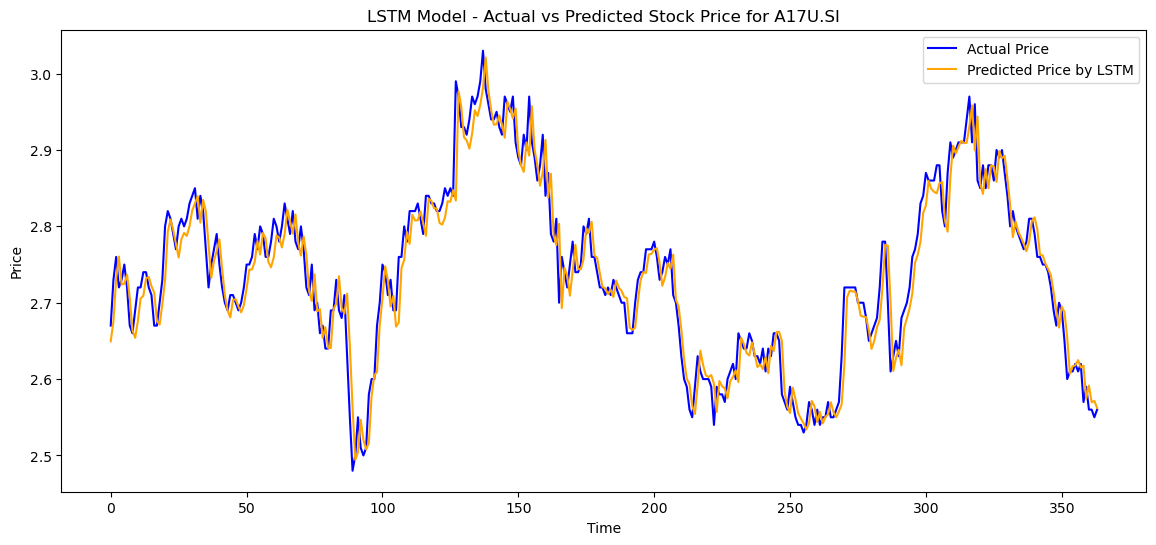

In [62]:
# Plot predictions vs actual values for Stock 2
plt.figure(figsize=(14, 6))
plt.plot(y_actual2, label='Actual Price', color='blue')
plt.plot(y_pred2, label='Predicted Price by LSTM', color='orange')
plt.title(f'LSTM Model - Actual vs Predicted Stock Price for {ticker2}')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [64]:
# Implement Fuzzy LSTM (FLSTM) Model
# Function to generate clusters and membership functions
def clustering_features(scaled_features, features_n_clusters):
    cluster_centers = []
    cluster_means = []
    cluster_sigmas = []

    for i in range(scaled_features.shape[1]):
        n_clusters = features_n_clusters[i]
        feature_data = scaled_features[:, i].reshape(-1, 1)

        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(feature_data)

        centers = kmeans.cluster_centers_.flatten().tolist()
        labels = kmeans.labels_

        means = []
        sigmas = []

        for j in range(n_clusters):
            cluster_points = feature_data[labels == j]
            cluster_mean = np.mean(cluster_points)
            cluster_sigma = np.std(cluster_points)

            means.append(cluster_mean)
            sigmas.append(cluster_sigma if cluster_sigma > 0 else 1e-6)  # Avoid division by zero

        sorted_cluster_features = sorted(zip(centers, means, sigmas), key=lambda x: x[0])
        centers, means, sigmas = map(list, zip(*sorted_cluster_features))

        cluster_centers.append(centers)
        cluster_means.append(means)
        cluster_sigmas.append(sigmas)

    return cluster_centers, cluster_means, cluster_sigmas

def generate_it2fmf(cluster_means, cluster_sigmas):
    num_features = len(cluster_means)
    it2fmf = []
    for i in range(num_features):
        feature_cluster_means = cluster_means[i]
        feature_cluster_sigmas = cluster_sigmas[i]
        feature_fmf_list = []

        for j in range(len(feature_cluster_means)):
            cluster_mean = feature_cluster_means[j]
            cluster_sigma = cluster_sigmas[i][j]

            fmf = IT2FS_Gaussian_UncertStd(
                domain=(0, 1),
                params=[cluster_mean, cluster_sigma, cluster_sigma / 2, 1.0]
            )
            feature_fmf_list.append(fmf)
        it2fmf.append(feature_fmf_list)
    return it2fmf


In [102]:
class FuzzyLayer(tf.keras.layers.Layer):
    def __init__(self, it2fmf):
        """
        Custom Fuzzy Layer.
        Parameters:
        - it2fmf: List of fuzzy membership functions for each feature.
        """
        super(FuzzyLayer, self).__init__()
        self.it2fmf = it2fmf  # Precomputed fuzzy membership functions
        self.fmf_count = 0
        for feature_fmf_list in it2fmf:
            self.fmf_count += len(feature_fmf_list)

    def call(self, inputs):
        """
        Compute fuzzy membership degrees for the input features.
        Parameters:
        - inputs: Input tensor of shape (batch_size, num_features).
        Returns:
        - fuzzified_inputs: Tensor of shape (batch_size, num_features, num_memberships).
        """
        feature_membership_values = []
        for i, feature_fmf_list in enumerate(self.it2fmf):
            feature_values = inputs[:, :, i:i+1]  # Extract the i-th feature (shape: batch_size, 1)
            # Compute fuzzy membership degrees for each fuzzy set in the feature
            for fmf in feature_fmf_list:
                # Compute the upper and lower membership degrees
                umf_values = tf.numpy_function(
                    lambda vals: tf.convert_to_tensor([fmf.umf(x, fmf.umf_params) for x in vals]),
                    [feature_values],
                    tf.float32
                )
                lmf_values = tf.numpy_function(
                    lambda vals: tf.convert_to_tensor([fmf.umf(x, fmf.lmf_params) for x in vals]),
                    [feature_values],
                    tf.float32
                )
                feature_membership_values.append(tf.squeeze(umf_values, axis=2))
                feature_membership_values.append(tf.squeeze(lmf_values, axis=2))
        stacked_membership_values = tf.stack(feature_membership_values, axis=0)
        fuzzified_inputs = tf.transpose(stacked_membership_values, perm=[1, 2, 0])
        fuzzified_inputs = tf.reshape(fuzzified_inputs, (-1, inputs.shape[1], self.fmf_count * 2))
        #fuzzified_inputs = tf.concat([inputs[:, :, 0:1], fuzzified_inputs], axis=-1)

        return fuzzified_inputs

In [172]:
# Prepare clusters and membership functions for Stock 2
features_n_clusters = [6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3]  # Adjust as needed
# Generate membership functions for Stock 1
scaled_features1 = feature_scaler1.transform(features1)
cluster_centers1, cluster_means1, cluster_sigmas1 = clustering_features(scaled_features1, features_n_clusters)
it2fmf1 = generate_it2fmf(cluster_means1, cluster_sigmas1)

# Generate membership functions for Stock 2
scaled_features2 = feature_scaler2.transform(features2)
cluster_centers2, cluster_means2, cluster_sigmas2 = clustering_features(scaled_features2, features_n_clusters)
it2fmf2 = generate_it2fmf(cluster_means2, cluster_sigmas2)

In [158]:
# Define FLSTM model for Stock 1
fuzzy_layr = FuzzyLayer(it2fmf1)
flstm_model_1 = tf.keras.Sequential([
    fuzzy_layr,
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

# Compile the FLSTM model
flstm_model_1.compile(optimizer='adam', loss='mean_squared_error')

In [160]:
# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

In [162]:
# Train FLSTM model on Stock 1
history_flstm_1 = flstm_model_1.fit(
    X_train1, y_train1,
    epochs=50,
    batch_size=20,
    validation_data=(X_test1, y_test1),
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

# Save FLSTM weights for simulated transfer learning
flstm_model_1.save_weights('flstm_stock1.weights.h5')

Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - loss: 0.0207 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - loss: 0.0022 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - loss: 0.0015 - val_loss: 9.7226e-04 - learning_rate: 0.0010
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step - loss: 0.0011 - val_loss: 8.1986e-04 - learning_rate: 0.0010
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - loss: 7.6553e-04 - val_loss: 6.4066e-04 - learning_rate: 0.0010
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - loss: 6.2973e-04 - val_loss: 5.7410e-04 - learning_rate: 0.0010
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - loss: 6.5431e-04 - val_loss: 4.3969e-04 - learning_rate: 0.0010
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - loss: 5.8288e-04 - val_loss: 3.4364e-04 - learning_rate: 0.0010
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 27s 162ms/step -

In [180]:
# Define FLSTM model for Stock 2
fuzzi_layer2 = FuzzyLayer(it2fmf2)
flstm_model2 = tf.keras.Sequential([
    fuzzi_layer2,
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

# Load pre-trained weights from FLSTM model trained on Stock 1 (commented out)
# flstm_model2.load_weights('flstm_stock1_weights.h5')

# Compile the FLSTM model
flstm_model2.compile(optimizer='adam', loss='mean_squared_error')

# Train FLSTM model on Stock 2
history_flstm2 = flstm_model2.fit(
    X_train2, y_train2,
    epochs=25,
    batch_size=20,
    validation_data=(X_test2, y_test2),
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 27s 138ms/step - loss: 0.0647 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 2/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - loss: 0.0048 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 3/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - loss: 0.0025 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 4/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - loss: 9.9077e-04 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 5/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - loss: 8.3917e-04 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 6/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - loss: 7.1318e-04 - val_loss: 8.7088e-04 - learning_rate: 0.0010
Epoch 7/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - loss: 5.7193e-04 - val_loss: 8.7089e-04 - learning_rate: 0.0010


In [190]:
print(f"\nMetrics for {ticker2} FLSTM Model:")
y_pred_flstm2, y_actual_flstm2, mse_flstm, mae_flstm, mape_flstm, r2_flstm, theils_u_flstm = evaluate_model(
    flstm_model1, X_test1, y_test1, target_scaler1
)


Metrics for A17U.SI FLSTM Model:
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step
Mean Squared Error: 0.0006
Mean Absolute Error: 0.0194
Mean Absolute Percentage Error: 0.88%
R-squared: 0.8732
Theil's U Statistic: 0.0113


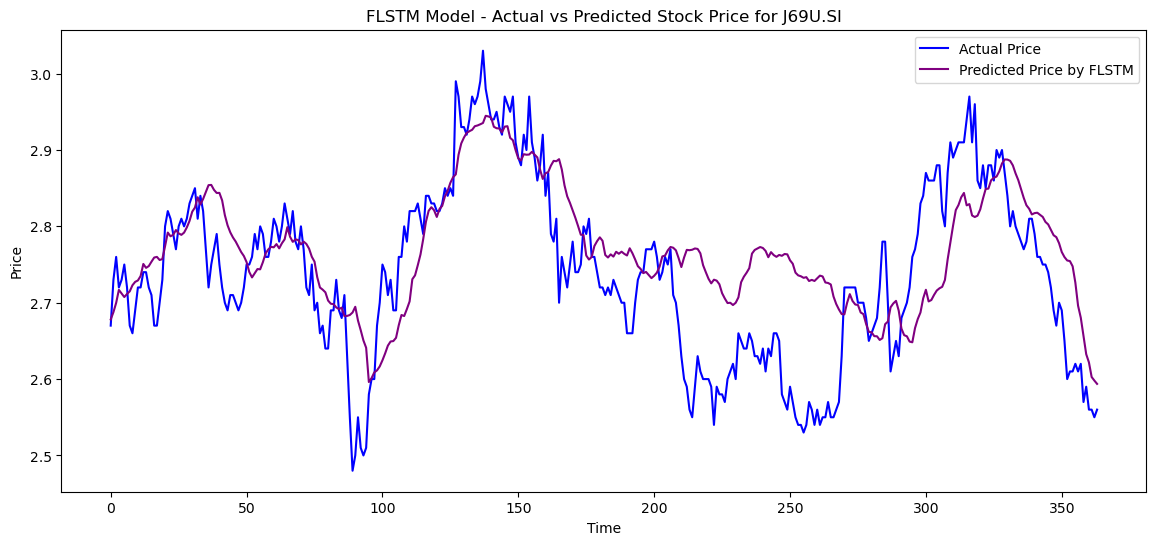

In [214]:
# Plot predictions vs actual values for FLSTM model on Stock 2
plt.figure(figsize=(14, 6))
plt.plot(y_actual_flstm, label='Actual Price', color='blue')
plt.plot(y_pred_flstm, label='Predicted Price by FLSTM', color='purple')
plt.title(f'FLSTM Model - Actual vs Predicted Stock Price for {ticker1}')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

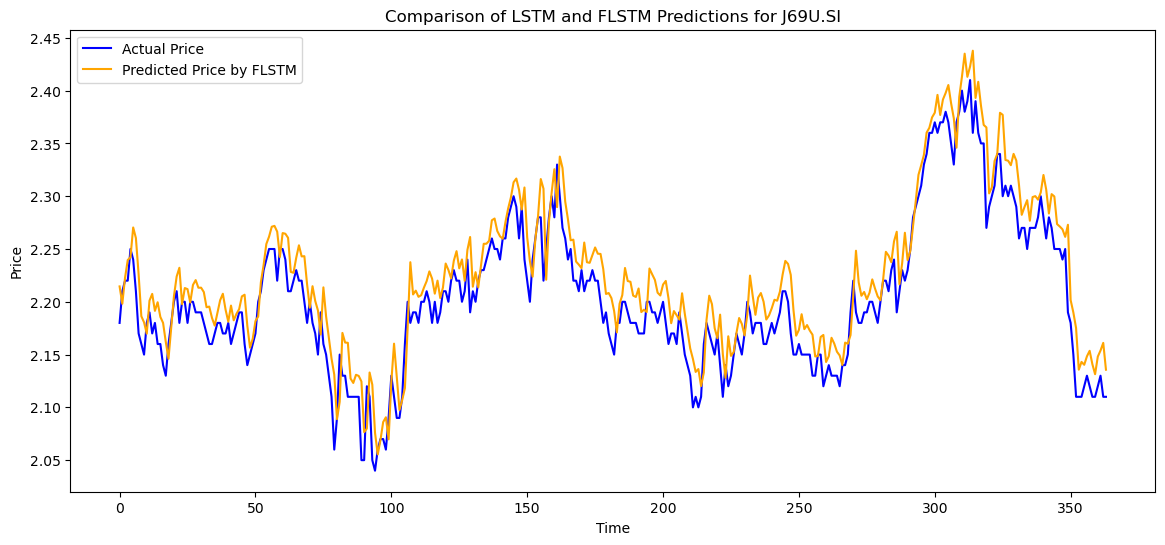

In [212]:
# Compare LSTM and FLSTM predictions
plt.figure(figsize=(14, 6))
plt.plot(y_actual2, label='Actual Price', color='blue')
plt.plot(y_pred2, label='Predicted Price by FLSTM', color='orange')
plt.title(f'Comparison of LSTM and FLSTM Predictions for {ticker1}')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [199]:
# Calculate and print metrics comparison
print(f"\nComparison of Metrics for {ticker2}:")
print(f"{'Metric':<30}{'LSTM':<15}{'FLSTM':<15}")
print(f"{'-'*60}")
print(f"{'Mean Squared Error':<30}{mse_lstm:.4f}{mse_flstm:<15.4f}")
print(f"{'Mean Absolute Error':<30}{mae_lstm:.4f}{mae_flstm:<15.4f}")
print(f"{'Mean Absolute Percentage Error':<30}{mape_lstm:.2f}%{mape_flstm:<15.2f}%")
print(f"{'R-squared':<30}{r2_lstm:.4f}{r2_flstm:<15.4f}")
print(f"{'Theil\'s U Statistic':<30}{theils_u_lstm:.4f}{theils_u_flstm:<15.4f}")


Comparison of Metrics for A17U.SI:
Metric                        LSTM           FLSTM          
------------------------------------------------------------
Mean Squared Error            0.00090.0006         
Mean Absolute Error           0.02530.0194         
Mean Absolute Percentage Error1.15%0.88           %
R-squared                     0.80900.8732         
Theil's U Statistic           0.01380.0113         


In [202]:
# Functions to calculate transaction signals and portfolio
def calculate_transaction_signals(predicted_price, price_change_threshold):
    # predicted_price: Rescaled predicted stock price
    # price_change_threshold: Set a minimum price change threshold to filter minor fluctuations
    buy_signals = [np.nan]
    sell_signals = [np.nan]

    for i in range(1, len(predicted_price)):
        price_diff = predicted_price[i] - predicted_price[i - 1]
        if price_diff > price_change_threshold:  # Significant increase
            buy_signals.append(predicted_price[i])
            sell_signals.append(np.nan)
        elif price_diff < -price_change_threshold:  # Significant decrease
            sell_signals.append(predicted_price[i])
            buy_signals.append(np.nan)
        else:
            buy_signals.append(np.nan)
            sell_signals.append(np.nan)
    return buy_signals, sell_signals

def calculate_portfolio(buy_signals, sell_signals, actual_price, transaction_rate):
    actions = np.zeros(len(actual_price))
    for i in range(len(actions)):
        if not np.isnan(buy_signals[i]):
            actions[i] = 1  # Buy
        elif not np.isnan(sell_signals[i]):
            actions[i] = -1  # Sell
        else:
            actions[i] = 0  # Hold

    # Calculate portfolio returns
    portfolio = [1.0]  # Starting portfolio value
    for i in range(1, len(actual_price)):
        r_t = (actual_price[i] / actual_price[i - 1]) - 1  # Return rate
        action_change = abs(actions[i] - actions[i - 1])  # Change in action to capture transaction cost
        R_t = (1 + actions[i - 1] * r_t) * (1 - transaction_rate * action_change)
        portfolio.append(portfolio[-1] * R_t)
    return portfolio

In [204]:
# Calculate portfolio returns and signals for LSTM and FLSTM models
transaction_rate = 0.005  # Transaction cost rate (0.5%)
price_change_threshold = 0.01  # Threshold for significant price change

# For LSTM model
LSTM_buy_signals, LSTM_sell_signals = calculate_transaction_signals(y_pred2, price_change_threshold)
LSTM_portfolio = calculate_portfolio(LSTM_buy_signals, LSTM_sell_signals, y_actual2, transaction_rate)

# For FLSTM model
FLSTM_buy_signals, FLSTM_sell_signals = calculate_transaction_signals(y_pred_flstm, price_change_threshold)
FLSTM_portfolio = calculate_portfolio(FLSTM_buy_signals, FLSTM_sell_signals, y_actual_flstm, transaction_rate)

# Calculate baseline buy and sell signals using moving averages
df2_test = df2.iloc[-len(y_actual2):].copy()
df2_test['Signal'] = np.where(df2_test['Short_Term_SMA'] > df2_test['Long_Term_SMA'], 1.0, 0.0)
baseline_signals = df2_test['Signal'].diff().fillna(0).values

baseline_buy_signals = []
baseline_sell_signals = []
for i in range(len(baseline_signals)):
    if baseline_signals[i] == 1:
        baseline_buy_signals.append(y_actual2[i])
        baseline_sell_signals.append(np.nan)
    elif baseline_signals[i] == -1:
        baseline_sell_signals.append(y_actual2[i])
        baseline_buy_signals.append(np.nan)
    else:
        baseline_buy_signals.append(np.nan)
        baseline_sell_signals.append(np.nan)

baseline_portfolio = calculate_portfolio(baseline_buy_signals, baseline_sell_signals, y_actual2, transaction_rate)

In [ ]:
# Plot portfolio performance
plt.figure(figsize=(14, 8))
plt.plot(baseline_portfolio, label='Baseline Portfolio', color='green')
plt.plot(LSTM_portfolio, label='LSTM Portfolio', color='orange')
plt.plot(FLSTM_portfolio, label='FLSTM Portfolio', color='purple')
plt.title(f'Portfolio Performance for {ticker2}')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

# Print final portfolio values
print(f"Final portfolio value for Baseline strategy: {baseline_portfolio[-1]:.4f}")
print(f"Final portfolio value for LSTM strategy: {LSTM_portfolio[-1]:.4f}")
print(f"Final portfolio value for FLSTM strategy: {FLSTM_portfolio[-1]:.4f}")